# 1 Setup

## 1.1 Setups

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
!pip install ethnicolr
!pip install pytorch-tabnet
!pip install torch

from ethnicolr import census_ln

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.5/39.5 MB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 787.2 kB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1.2 Import data

In [ ]:
# Get data
cand_data = pd.read_excel('/content/drive/MyDrive/Candidate Platforms and Endorsements/Data files/merged_final_candidate_data.xlsx')
cand_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31936 entries, 0 to 31935
Columns: 132 entries, Unnamed: 0 to gender
dtypes: float64(74), int64(37), object(21)
memory usage: 32.2+ MB


In [ ]:
cand_data

,Unnamed: 0,cntyname,year,place,last,first,baldesig,office,incumb,co#,...,year_1999,year_2003,year_2005,year_2007,year_2011,year_2015,year_2021,year_2013,year_2017,gender
0,0,alameda,1996,alameda board of education,greely,gail ann,incumbent and parent,BOARD MEMBER,y,1,...,0,0,0,0,0,0,0,0,0,0.0
1,1,alameda,1996,alameda board of education,guenther,barbara m.,parent/case manager/advocate,BOARD MEMBER,n,1,...,0,0,0,0,0,0,0,0,0,0.0
2,2,alameda,1996,alameda board of education,huie,sam,grandparent/computer professional,BOARD MEMBER,n,1,...,0,0,0,0,0,0,0,0,0,1.0
3,3,alameda,1996,alameda board of education,linebarry,claude s. butch,management consultant,BOARD MEMBER,n,1,...,0,0,0,0,0,0,0,0,0,1.0
4,4,alameda,1996,alameda board of education,mcmahon,michael,systems analyst,BOARD MEMBER,n,1,...,0,0,0,0,0,0,0,0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31931,37723,yuba,2016,wheatland union high,schweitz,debbie,incumbent,SCHOOL BOARD MEMBER,y,58,...,0,0,0,0,0,0,0,0,0,0.0
31932,37724,yuba,2020,wheatland union high,agles,patti,no ballot designation,SCHOOL BOARD MEMBER,n,58,...,0,0,0,0,0,0,0,0,0,0.0
31933,37725,yuba,2020,wheatland union high,forest,greg,no ballot designation,SCHOOL BOARD MEMBER,n,58,...,0,0,0,0,0,0,0,0,0,1.0
31934,37726,yuba,2020,wheatland union high,mchugh,brendan,no ballot designation,SCHOOL BOARD MEMBER,n,58,...,0,0,0,0,0,0,0,0,0,1.0


In [ ]:
# Replace candidates district with standardized DOE match
cand_data['place'] = cand_data['matches']
del cand_data['matches']
cand_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31936 entries, 0 to 31935
Columns: 131 entries, Unnamed: 0 to gender
dtypes: float64(74), int64(37), object(20)
memory usage: 31.9+ MB


In [ ]:
# Standardize elected/new elected to be 1 if elected, 0 if not
cand_data['elected'] = cand_data['elected'].replace(2, 0)
cand_data['newelected'] = cand_data['newelected'].replace(2, 0)
cand_data['newelected'] = cand_data['newelected'].replace(3, 0) # Runoff, not sure what to do???
# Standardize incumb to 1 if incumbent, 0 if not
cand_data['incumb'] = cand_data['incumb'].replace('n', 0)
cand_data['incumb'] = cand_data['incumb'].replace('y', 1)
cand_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31936 entries, 0 to 31935
Columns: 131 entries, Unnamed: 0 to gender
dtypes: float64(74), int64(38), object(19)
memory usage: 31.9+ MB


In [ ]:
# Only get rows with candidate statements
#cand_data = cand_data.dropna()
#cand_data = cand_data[(cand_data['priorities'] != 'NA/NO BIO') & (cand_data['priorities'] != 'NA/MISSING INFO') & (cand_data['place'] != 'none')]
cand_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31936 entries, 0 to 31935
Columns: 131 entries, Unnamed: 0 to gender
dtypes: float64(74), int64(38), object(19)
memory usage: 31.9+ MB


In [ ]:
# add ethnicity features https://ethnicolr.readthedocs.io/ethnicolr.html
from ethnicolr import pred_wiki_ln, pred_wiki_name

temp = cand_data[['first', 'last']].copy()
ethnicities = pred_wiki_name(temp, 'last', 'first')
cand_data = pd.merge(cand_data, ethnicities, on=['first', 'last'], how='left')
ethnicities.info()
cand_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24395 entries, 0 to 24394
Data columns (total 16 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   first                                  24395 non-null  object 
 1   last                                   24395 non-null  object 
 2   Asian,GreaterEastAsian,EastAsian       24395 non-null  float32
 3   Asian,GreaterEastAsian,Japanese        24395 non-null  float32
 4   Asian,IndianSubContinent               24395 non-null  float32
 5   GreaterAfrican,Africans                24395 non-null  float32
 6   GreaterAfrican,Muslim                  24395 non-null  float32
 7   GreaterEuropean,British                24395 non-null  float32
 8   GreaterEuropean,EastEuropean           24395 non-null  float32
 9   GreaterEuropean,Jewish                 24395 non-null  float32
 10  GreaterEuropean,WestEuropean,French    24395 non-null  float32
 11  Gr

In [ ]:
list(cand_data.columns.values)

['Unnamed: 0',
 'cntyname',
 'year',
 'place',
 'last',
 'first',
 'baldesig',
 'office',
 'incumb',
 'co#',
 'multi_candid',
 'multi_co',
 'raceid',
 'percent',
 'elected',
 'newelected',
 'priorities',
 'leaid',
 'lea_name',
 'fips',
 'state_leaid',
 'street_mailing',
 'city_mailing',
 'state_mailing',
 'zip_mailing',
 'zip4_mailing',
 'street_location',
 'city_location',
 'state_location',
 'zip_location',
 'zip4_location',
 'phone',
 'latitude',
 'longitude',
 'urban_centric_locale',
 'cbsa',
 'cbsa_type',
 'csa',
 'cmsa',
 'necta',
 'county_code',
 'county_name',
 'congress_district_id',
 'bureau_indian_education',
 'supervisory_union_number',
 'agency_type',
 'agency_level',
 'boundary_change_indicator',
 'agency_charter_indicator',
 'lowest_grade_offered',
 'highest_grade_offered',
 'number_of_schools',
 'enrollment',
 'spec_ed_students',
 'english_language_learners',
 'migrant_students',
 'teachers_prek_fte',
 'teachers_kindergarten_fte',
 'teachers_elementary_fte',
 'teachers_

In [ ]:
cleaned_data = cand_data[['leaid',
                          'year',
                          'incumb',
                          'longitude',
                          'latitude',
                          'enrollment',
                          'est_population_total',
                          'english_language_learners',
                          'est_population_5_17_pct',
                          'est_population_5_17_poverty_pct',
                          'number_of_schools',
                          #'topic_0',
                          #'topic_1',
                          ##'topic_2',
                          #'topic_3',
                          ##'topic_4',
                          #'topic_5',
                          #'topic_6',
                          #'topic_7',
                          #'topic_8',
                          #'topic_9',
                          'leaid_year_count',
                          'year_1996',
                          'year_2000',
                          'year_2004',
                          'year_2006',
                          'year_2010',
                          'year_1998',
                          'year_2008',
                          'year_2012',
                          'year_2016',
                          'year_2020',
                          'year_2014',
                          'year_2018',
                          'year_2022',
                          'year_2002',
                          'year_2019',
                          'year_1997',
                          'year_2001',
                          'year_2009',
                          'year_1999',
                          'year_2003',
                          'year_2005',
                          'year_2007',
                          'year_2011',
                          'year_2015',
                          'year_2021',
                          'year_2013',
                          'year_2017',
                           'Asian,GreaterEastAsian,EastAsian',
                           'Asian,GreaterEastAsian,Japanese',
                           'Asian,IndianSubContinent',
                           'GreaterAfrican,Africans',
                           'GreaterAfrican,Muslim',
                           'GreaterEuropean,British',
                           'GreaterEuropean,EastEuropean',
                           'GreaterEuropean,Jewish',
                           'GreaterEuropean,WestEuropean,French',
                           'GreaterEuropean,WestEuropean,Germanic',
                           'GreaterEuropean,WestEuropean,Hispanic',
                           'GreaterEuropean,WestEuropean,Italian',
                           'GreaterEuropean,WestEuropean,Nordic',
                          # 'race',
                          'gender',
                          'newelected'
                           ]]
cleaned_data = cleaned_data[(cleaned_data['leaid'] != -1) & cleaned_data['leaid'].notna()]
cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31936 entries, 0 to 31935
Data columns (total 54 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   leaid                                  31936 non-null  int64  
 1   year                                   31936 non-null  int64  
 2   incumb                                 31936 non-null  int64  
 3   longitude                              16012 non-null  float64
 4   latitude                               16012 non-null  float64
 5   enrollment                             29407 non-null  float64
 6   est_population_total                   26060 non-null  float64
 7   english_language_learners              24580 non-null  float64
 8   est_population_5_17_pct                26060 non-null  float64
 9   est_population_5_17_poverty_pct        26060 non-null  float64
 10  number_of_schools                      29419 non-null  float64
 11  le

In [ ]:
grouped = cleaned_data.groupby('leaid')
print(cleaned_data[['longitude', 'latitude']].isnull().sum())

print(len(grouped))
ids = {}

# Iterate through each group
for leaid, group in grouped:
    # print(f"Processing group with leaid: {leaid}")

    # Check if there are any rows with non-null 'longitude' and 'latitude'
    valid_rows = cleaned_data[['longitude', 'latitude']].notnull().all(axis=1)

    if valid_rows.any():
        #print(f"Found rows ({len(valid_rows)} of them) with valid 'longitude' and 'latitude' in this group. ")
        # Check if there are missing values before filling
        #missing_before = group[['longitude', 'latitude']].isnull().sum()
        #print(f"Missing values before filling:\n{missing_before}")

        mean_longitude = cleaned_data.loc[valid_rows, 'longitude'].mean()
        mean_latitude = cleaned_data.loc[valid_rows, 'latitude'].mean()

        # Forward fill missing values in 'longitude' and 'latitude' with mean values
        cleaned_data['longitude'].fillna(value=mean_longitude, inplace=True)
        cleaned_data['latitude'].fillna(value=mean_latitude, inplace=True)

        # Check if there are missing values after filling
        #missing_after = cleaned_data.loc[group.index, ['longitude', 'latitude']].isnull().sum()

    else:
        print(f"No rows with valid 'longitude' and 'latitude' in this group.")

# Check if there are still any missing values
missing_values = cleaned_data[['longitude', 'latitude']].isnull().sum()
print(f"Remaining missing values: {missing_values}")
# print(len(ids.keys()))


longitude    15924
latitude     15924
dtype: int64
834
Remaining missing values: longitude    0
latitude     0
dtype: int64


In [ ]:
cleaned_data.sort_values(by=['leaid', 'year'], inplace=True)

# Forward fill missidng values in 'percent' column within each group ('leaid')
cleaned_data['est_population_total'] = cleaned_data.groupby('leaid')['est_population_total'].fillna(method='ffill')
cleaned_data['est_population_5_17_poverty_pct'] = cleaned_data.groupby('leaid')['est_population_5_17_poverty_pct'].fillna(method='ffill')
cleaned_data['english_language_learners'] = cleaned_data.groupby('leaid')['english_language_learners'].fillna(method='ffill')
cleaned_data['est_population_5_17_pct'] = cleaned_data.groupby('leaid')['est_population_5_17_pct'].fillna(method='ffill')
cleaned_data['number_of_schools'] = cleaned_data.groupby('leaid')['number_of_schools'].fillna(method='ffill')
cleaned_data['enrollment'] = cleaned_data.groupby('leaid')['enrollment'].fillna(method='ffill')


In [ ]:
cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31936 entries, 7687 to 18405
Data columns (total 54 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   leaid                                  31936 non-null  int64  
 1   year                                   31936 non-null  int64  
 2   incumb                                 31936 non-null  int64  
 3   longitude                              31936 non-null  float64
 4   latitude                               31936 non-null  float64
 5   enrollment                             31734 non-null  float64
 6   est_population_total                   28433 non-null  float64
 7   english_language_learners              28846 non-null  float64
 8   est_population_5_17_pct                28433 non-null  float64
 9   est_population_5_17_poverty_pct        28433 non-null  float64
 10  number_of_schools                      31734 non-null  float64
 11 

In [ ]:
cleaned_data = cleaned_data.dropna()

In [ ]:
cleaned_data

,leaid,year,incumb,longitude,latitude,enrollment,est_population_total,english_language_learners,est_population_5_17_pct,est_population_5_17_poverty_pct,...,"GreaterEuropean,British","GreaterEuropean,EastEuropean","GreaterEuropean,Jewish","GreaterEuropean,WestEuropean,French","GreaterEuropean,WestEuropean,Germanic","GreaterEuropean,WestEuropean,Hispanic","GreaterEuropean,WestEuropean,Italian","GreaterEuropean,WestEuropean,Nordic",gender,newelected
7694,600001,1999,1,-119.715134,36.098043,2073.0,11767.0,69.0,0.225546,0.047852,...,0.816151,0.010918,0.045141,0.069955,0.027756,0.000754,0.009021,0.001182,1.0,1
7695,600001,1999,0,-119.715134,36.098043,2073.0,11767.0,69.0,0.225546,0.047852,...,0.966970,0.000229,0.003852,0.011908,0.000592,0.000653,0.001470,0.002571,1.0,0
7696,600001,1999,1,-119.715134,36.098043,2073.0,11767.0,69.0,0.225546,0.047852,...,0.928632,0.002138,0.007658,0.020328,0.009622,0.011897,0.004484,0.004482,0.0,0
7697,600001,1999,0,-119.715134,36.098043,2073.0,11767.0,69.0,0.225546,0.047852,...,0.279443,0.001193,0.051068,0.095143,0.007148,0.027309,0.509167,0.011650,1.0,1
7698,600001,1999,0,-119.715134,36.098043,2073.0,11767.0,69.0,0.225546,0.047852,...,0.535978,0.021622,0.075761,0.066853,0.010170,0.039297,0.146736,0.010757,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18401,691136,2012,1,-121.556038,36.880402,1170.0,4586.0,346.0,0.155909,0.102098,...,0.082699,0.002056,0.032495,0.625221,0.001872,0.199202,0.020686,0.001891,1.0,0
18402,691136,2016,1,-121.556041,36.880400,1118.0,4790.0,262.0,0.147599,0.168317,...,0.866566,0.000924,0.041042,0.012319,0.001485,0.019721,0.037012,0.005065,0.0,1
18403,691136,2016,0,-121.556041,36.880400,1118.0,4790.0,262.0,0.147599,0.168317,...,0.922197,0.000116,0.009274,0.038047,0.000438,0.015586,0.006289,0.000097,1.0,1
18404,691136,2016,1,-121.556041,36.880400,1118.0,4790.0,262.0,0.147599,0.168317,...,0.034682,0.003979,0.097545,0.018057,0.010595,0.591532,0.201998,0.000852,0.0,1


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier


features = cleaned_data[[ 'incumb',
                          'longitude',
                          'latitude',
                          'enrollment',
                          'est_population_total',
                          'english_language_learners',
                          'est_population_5_17_pct',
                          'est_population_5_17_poverty_pct',
                          'number_of_schools',
                          #'topic_0',
                          #'topic_1',
                          #'topic_2',
                          #'topic_3',
                          #'topic_4',
                          #'topic_5',
                          ##'topic_6',
                          #'topic_7',
                          #'topic_8',
                          #'topic_9',
                          #'leaid_year_count',
                          #'year_1996',
                          ##'year_2000',
                          #'year_2004',
                          #'year_2006',
                          ##'year_2010',
                          #'year_1998',
                          #'year_2008',
                          #'year_2012',
                          ##'year_2016',
                          #'year_2020',
                          #'year_2014',
                          #'year_2018',
                          #'year_2022',
                          #'year_2002',
                          #'year_2019',
                          #'year_1997',
                          #'year_2001',
                          #'year_2009',
                          #'year_1999',
                          #'year_2003',
                          #'year_2005',
                          #'year_2007',
                          #'year_2011',
                          #'year_2015',
                          #'year_2021',
                          #'year_2013',
                          #'year_2017',
                          'Asian,GreaterEastAsian,EastAsian',
                          'Asian,GreaterEastAsian,Japanese',
                          'Asian,IndianSubContinent',
                          'GreaterAfrican,Africans',
                          'GreaterAfrican,Muslim',
                          'GreaterEuropean,British',
                          'GreaterEuropean,EastEuropean',
                          'GreaterEuropean,Jewish',
                          'GreaterEuropean,WestEuropean,French',
                          'GreaterEuropean,WestEuropean,Germanic',
                          'GreaterEuropean,WestEuropean,Hispanic',
                          'GreaterEuropean,WestEuropean,Italian',
                          'GreaterEuropean,WestEuropean,Nordic',
                          'gender',
                          #'race'
                          ]]

labels = cleaned_data.iloc[:, -1]  # Extracting the last column as labels

features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27120 entries, 7694 to 18405
Data columns (total 23 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   incumb                                 27120 non-null  int64  
 1   longitude                              27120 non-null  float64
 2   latitude                               27120 non-null  float64
 3   enrollment                             27120 non-null  float64
 4   est_population_total                   27120 non-null  float64
 5   english_language_learners              27120 non-null  float64
 6   est_population_5_17_pct                27120 non-null  float64
 7   est_population_5_17_poverty_pct        27120 non-null  float64
 8   number_of_schools                      27120 non-null  float64
 9   Asian,GreaterEastAsian,EastAsian       27120 non-null  float32
 10  Asian,GreaterEastAsian,Japanese        27120 non-null  float32
 11 

In [ ]:
labels.unique()

array([1, 0])

In [ ]:
unique_labels, counts = np.unique(labels, return_counts=True)

# Find the index of '1' in unique_labels
index_of_1 = np.where(unique_labels == 1)[0]
index_of_0 = np.where(unique_labels == 0)[0]

# Check if '1' is present in unique_labels
if index_of_1.size > 0:
    count_of_1 = counts[index_of_1][0]
    count_of_0 = counts[index_of_0][0]
    print("Count of '1' in labels:", count_of_1)
    print("Count of '0' in labels:", count_of_0)

else:
    print("Value '1' not found in labels.")

Count of '1' in labels: 13836
Count of '0' in labels: 13284


In [ ]:
# Split the data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(features, labels, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.00001, random_state=42)

feature_names = X_train.columns  # Assuming X_train is a DataFrame

# Print out the shapes of the datasets
print("Train set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Train set shape: (21696, 23) (21696,)
Validation set shape: (5423, 23) (5423,)
Test set shape: (1, 23) (1,)


### **2) Models**

## Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

# Create a Gaussian Naive Bayes model
naive_bayes_model = GaussianNB()

# Train the Naive Bayes model
naive_bayes_model.fit(X_train, y_train)

# Make predictions on the training set
y_train_pred_nb = naive_bayes_model.predict(X_train)
accuracy_train_nb = accuracy_score(y_train, y_train_pred_nb)
print("Naive Bayes Training Accuracy:", accuracy_train_nb)

# Make predictions on the validation set
y_val_pred_nb = naive_bayes_model.predict(X_val)
accuracy_val_nb = accuracy_score(y_val, y_val_pred_nb)
print("Naive Bayes Validation Accuracy:", accuracy_val_nb)

Naive Bayes Training Accuracy: 0.5167772861356932
Naive Bayes Validation Accuracy: 0.5207449751060299


## 2.1 Logistic Regression

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from torch.optim import lr_scheduler


Epoch [10/1500], Training Loss: 0.7229, Training Accuracy: 0.5011, Validation Loss: 0.7239, Validation Accuracy: 0.4990
Epoch [20/1500], Training Loss: 0.7175, Training Accuracy: 0.5069, Validation Loss: 0.7183, Validation Accuracy: 0.5060
Epoch [30/1500], Training Loss: 0.7125, Training Accuracy: 0.5138, Validation Loss: 0.7130, Validation Accuracy: 0.5139
Epoch [40/1500], Training Loss: 0.7077, Training Accuracy: 0.5228, Validation Loss: 0.7080, Validation Accuracy: 0.5228
Epoch [50/1500], Training Loss: 0.7033, Training Accuracy: 0.5296, Validation Loss: 0.7034, Validation Accuracy: 0.5289
Epoch [60/1500], Training Loss: 0.6992, Training Accuracy: 0.5380, Validation Loss: 0.6990, Validation Accuracy: 0.5349
Epoch [70/1500], Training Loss: 0.6953, Training Accuracy: 0.5445, Validation Loss: 0.6949, Validation Accuracy: 0.5438
Epoch [80/1500], Training Loss: 0.6917, Training Accuracy: 0.5529, Validation Loss: 0.6911, Validation Accuracy: 0.5563
Epoch [90/1500], Training Loss: 0.6883, 

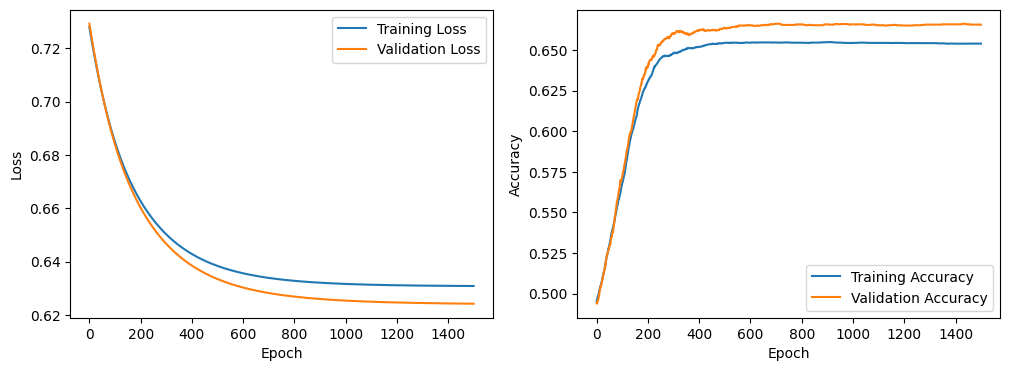

In [ ]:
# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Define logistic regression model
class LogisticRegression(nn.Module):
    def __init__(self, input_size):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.linear(x)
        out = self.sigmoid(out)
        return out

# Initialize the model, loss function, and optimizer
input_size = X_train_tensor.shape[1]
model = LogisticRegression(input_size)
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay = 1e-4)

# Training loop
num_epochs = 1500
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    # Forward pass
    outputs_tensor = model(X_train_tensor)
    loss_tensor = criterion(outputs_tensor, y_train_tensor.view(-1, 1))

    # Calculate accuracy
    predictions_tensor = (outputs_tensor >= 0.5).float()
    accuracy_tensor = torch.mean((predictions_tensor == y_train_tensor.view(-1, 1)).float())

    # Backward and optimize
    optimizer.zero_grad()
    loss_tensor.backward()
    optimizer.step()

    # Validation loss and accuracy
    with torch.no_grad():
        val_outputs_tensor = model(X_val_tensor)
        val_loss_tensor = criterion(val_outputs_tensor, y_val_tensor.view(-1, 1))
        val_predictions_tensor = (val_outputs_tensor >= 0.5).float()
        val_accuracy_tensor = torch.mean((val_predictions_tensor == y_val_tensor.view(-1, 1)).float())

    # Save losses and accuracies for plotting
    train_losses.append(loss_tensor.item())
    val_losses.append(val_loss_tensor.item())
    train_accuracies.append(accuracy_tensor.item())
    val_accuracies.append(val_accuracy_tensor.item())

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {loss_tensor.item():.4f}, Training Accuracy: {accuracy_tensor.item():.4f}, Validation Loss: {val_loss_tensor.item():.4f}, Validation Accuracy: {val_accuracy_tensor.item():.4f}')

# Plotting the training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 2.2 K-Nearest Neighbors

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Create a KNN model with k=3 (you can adjust the value of k)
knn_model = KNeighborsClassifier(n_neighbors=3)

# Train the KNN model
knn_model.fit(X_train, y_train)

# Make predictions on the training set
y_train_pred_knn = knn_model.predict(X_train)
accuracy_train_knn = accuracy_score(y_train, y_train_pred_knn)
print("KNN Training Accuracy:", accuracy_train_knn)

# Make predictions on the validation set
y_val_pred_knn = knn_model.predict(X_val)
accuracy_val_knn = accuracy_score(y_val, y_val_pred_knn)
print("KNN Validation Accuracy:", accuracy_val_knn)

KNN Training Accuracy: 0.7874262536873157
KNN Validation Accuracy: 0.59727088327494


## 2.3 Random Forests

Random Forest Training Accuracy: 0.6665283923303835
Random Forest Validation Accuracy: 0.6616264060483127


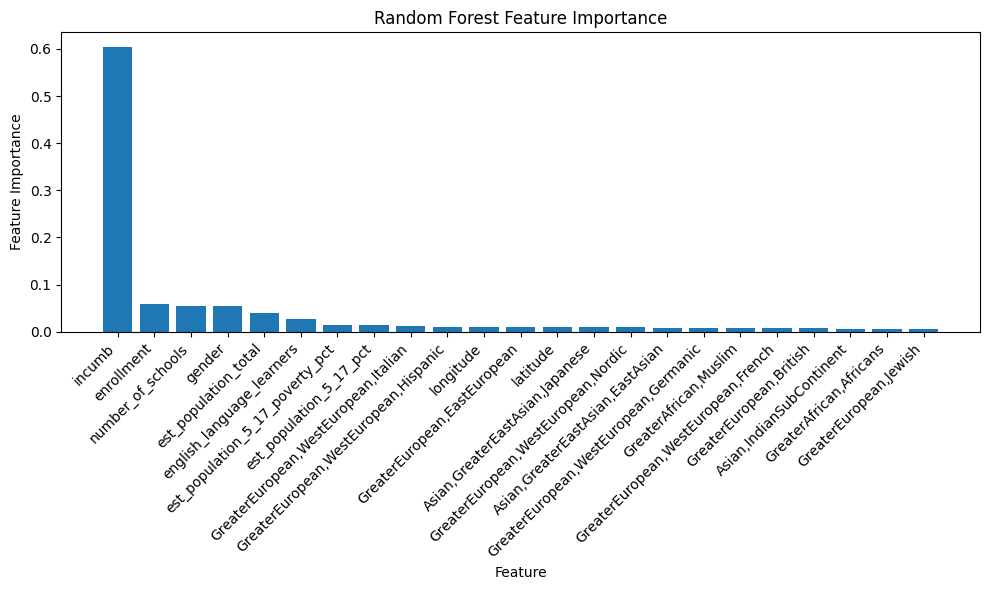

In [ ]:
# Train Random Forest
random_forest_model = RandomForestClassifier(random_state=41, max_depth=5)
random_forest_model.fit(X_train, y_train)

y_train_pred_rf = random_forest_model.predict(X_train)
accuracy_rf = accuracy_score(y_train, y_train_pred_rf)
print("Random Forest Training Accuracy:", accuracy_rf)

y_val_pred_rf = random_forest_model.predict(X_val)
accuracy_rf = accuracy_score(y_val, y_val_pred_rf)
print("Random Forest Validation Accuracy:", accuracy_rf)

feature_importances = random_forest_model.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(feature_importances)[::-1]

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(range(X_train.shape[1]), feature_importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), feature_names[indices], rotation=45, ha="right")
plt.xlabel("Feature")
plt.ylabel("Feature Importance")
plt.title("Random Forest Feature Importance")
plt.tight_layout()
plt.show()

## 2.4 Gradient Boosting Classifier

GBM Validation Accuracy: 0.6631016042780749


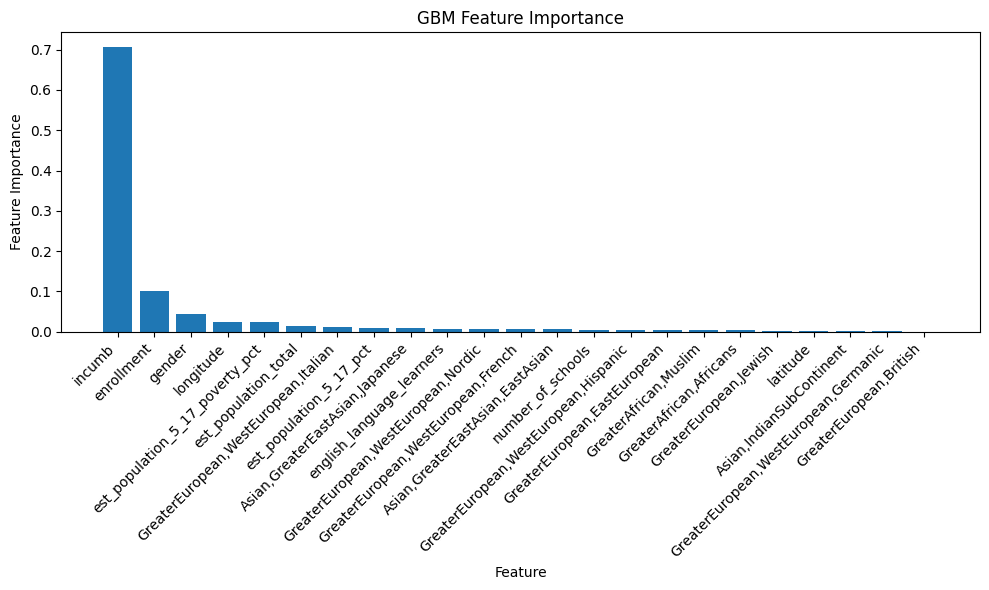

In [ ]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import make_scorer, accuracy_score
import numpy as np

# Assuming you have your data (X_train, y_train) and feature_names defined

# Create a Gradient Boosting Classifier
gbm_model = GradientBoostingClassifier(random_state=42, n_estimators=15, learning_rate=0.3, max_depth=3)

# Perform 5-fold cross-validation
#cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define the scoring metric (accuracy in this case)
#scorer = make_scorer(accuracy_score)

# Perform cross-validation and print the results
##cross_val_results = cross_val_score(gbm_model, X_train, y_train, cv=cv, scoring=scorer)
#print("Cross-Validation Results (Accuracy):", cross_val_results)
#print("Mean Accuracy:", np.mean(cross_val_results))

# Train the GBM model on the entire training set
gbm_model.fit(X_train, y_train)

# Make predictions on the validation set
y_val_pred_gbm = gbm_model.predict(X_val)
accuracy_val_gbm = accuracy_score(y_val, y_val_pred_gbm)
print("GBM Validation Accuracy:", accuracy_val_gbm)

# Feature importance plotting (similar to your original code)
feature_importances = gbm_model.feature_importances_
indices = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(10, 6))
plt.bar(range(X_train.shape[1]), feature_importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), feature_names[indices], rotation=45, ha="right")
plt.xlabel("Feature")
plt.ylabel("Feature Importance")
plt.title("GBM Feature Importance")
plt.tight_layout()
plt.show()

## 2.5 XGBoost

XGBoost Training Accuracy: 0.6580936578171092
XGBoost Validation Accuracy: 0.6686335976396829


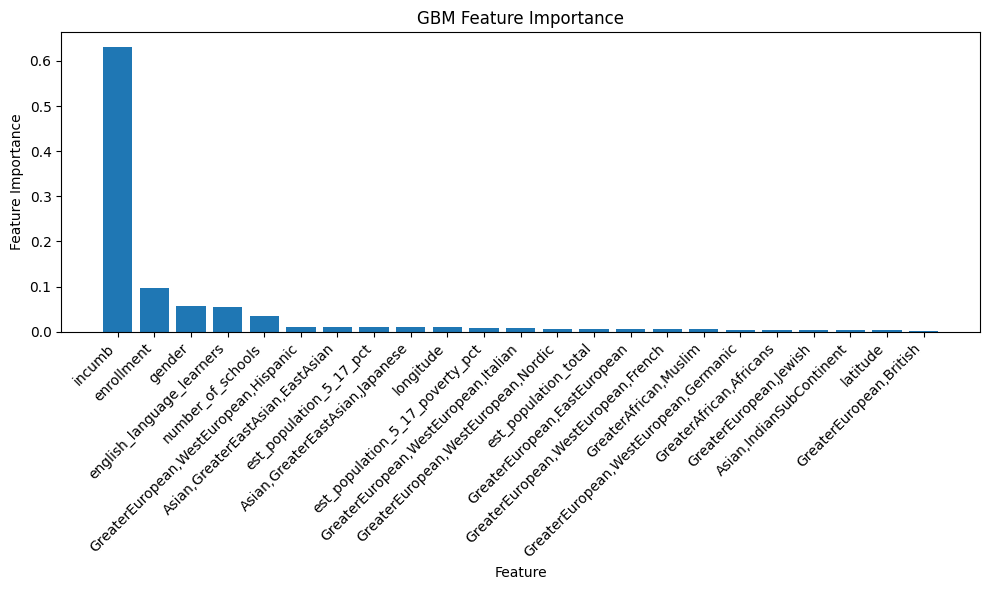

In [ ]:
xgboost_model = XGBClassifier(random_state=42, max_depth=1)
xgboost_model.fit(X_train, y_train)

y_train_pred_xgb = xgboost_model.predict(X_train)
accuracy_xgb = accuracy_score(y_train, y_train_pred_xgb)
print("XGBoost Training Accuracy:", accuracy_xgb)

y_val_pred_xgb = xgboost_model.predict(X_val)
accuracy_xgb = accuracy_score(y_val, y_val_pred_xgb)
print("XGBoost Validation Accuracy:", accuracy_xgb)


feature_importances = xgboost_model.feature_importances_

# Get the names of t he features

# Sort feature importances in descending order
indices = np.argsort(feature_importances)[::-1]

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(range(X_train.shape[1]), feature_importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), feature_names[indices], rotation=45, ha="right")
plt.xlabel("Feature")
plt.ylabel("Feature Importance")
plt.title("GBM Feature Importance")
plt.tight_layout()
plt.show()

## 2.6 SVMs

In [ ]:
# Train Support Vector Machine (SVM)
# svm_model = SVC(kernel='rbf', gamma=0.02,random_state=42)
svm_model = SVC(kernel='rbf', random_state=42)
svm_model.fit(X_train, y_train)

y_train_pred_svm = svm_model.predict(X_train)
accuracy_svm = accuracy_score(y_train, y_train_pred_svm)
print("SVM Training Accuracy:", accuracy_svm)

y_val_pred_svm = svm_model.predict(X_val)
accuracy_svm = accuracy_score(y_val, y_val_pred_svm)
print("SVM Validation Accuracy:", accuracy_svm)

SVM Training Accuracy: 0.6615966076696165
SVM Validation Accuracy: 0.665314401622718


In [ ]:
!pip install torch

## 2.7 Fully Connected Neural Network

LOG: Fold [1/5], Epoch [10/150], Training Loss: 0.6677, Training Accuracy: 0.6104, Validation Loss: 0.6662, Validation Accuracy: 0.6298
LOG: Fold [1/5], Epoch [20/150], Training Loss: 0.6469, Training Accuracy: 0.6534, Validation Loss: 0.6436, Validation Accuracy: 0.6541
LOG: Fold [1/5], Epoch [30/150], Training Loss: 0.6417, Training Accuracy: 0.6548, Validation Loss: 0.6421, Validation Accuracy: 0.6563
LOG: Fold [1/5], Epoch [40/150], Training Loss: 0.6386, Training Accuracy: 0.6543, Validation Loss: 0.6378, Validation Accuracy: 0.6569
LOG: Fold [1/5], Epoch [50/150], Training Loss: 0.6377, Training Accuracy: 0.6555, Validation Loss: 0.6393, Validation Accuracy: 0.6574
LOG: Fold [1/5], Epoch [60/150], Training Loss: 0.6374, Training Accuracy: 0.6555, Validation Loss: 0.6338, Validation Accuracy: 0.6597
LOG: Fold [1/5], Epoch [70/150], Training Loss: 0.6363, Training Accuracy: 0.6542, Validation Loss: 0.6377, Validation Accuracy: 0.6586
LOG: Fold [1/5], Epoch [80/150], Training Loss: 

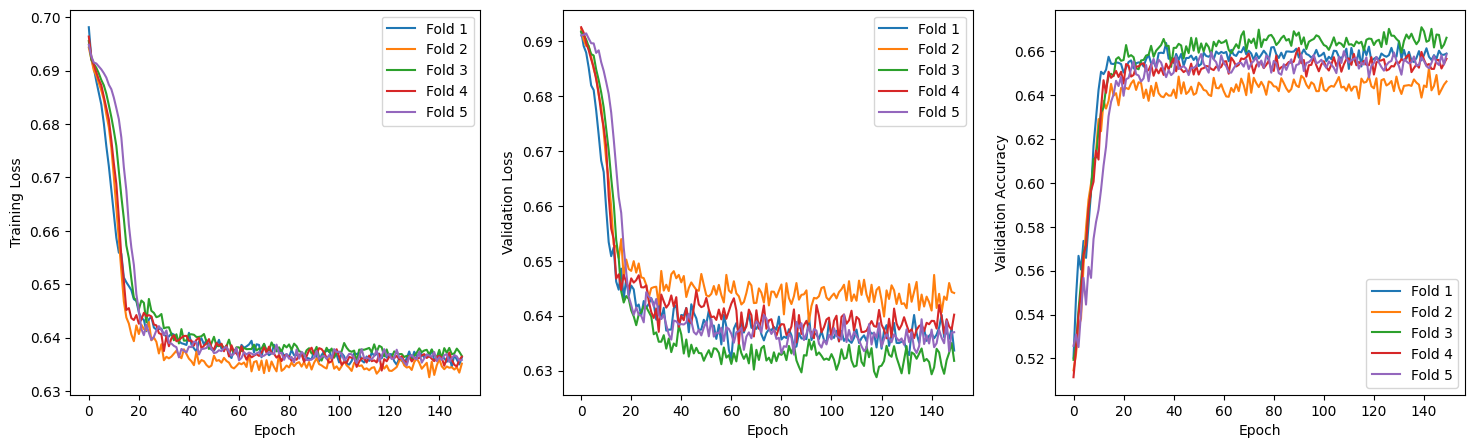

In [ ]:
# Define a simple neural network model
class NeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)  # Adjust dropout rate as needed
        self.fc2 = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

class LargerNeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super(LargerNeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.6)

        self.fc2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.6)

        self.fc3 = nn.Linear(64, 32)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(0.6)

        self.fc4 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout1(x)

        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout2(x)

        x = self.fc3(x)
        x = self.relu3(x)
        x = self.dropout3(x)

        x = self.fc4(x)
        x = self.sigmoid(x)
        return x


from sklearn.model_selection import StratifiedKFold

# Combine train and validation sets for cross-validation split
X_combined = torch.cat([X_train_tensor, X_val_tensor], dim=0)
y_combined = torch.cat([y_train_tensor, y_val_tensor], dim=0)

# Set the number of folds for cross-validation
num_folds = 5
kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Lists to store results from each fold
all_train_losses = []
all_val_losses = []
all_train_accuracies = []
all_val_accuracies = []
all_test_accuracies = []

best_val_accuracies = []
best_train_accuracies = []

for fold, (train_index, val_index) in enumerate(kf.split(X_combined, y_combined)):
    # Split data into training and validation sets
    X_train_fold, X_val_fold = X_combined[train_index], X_combined[val_index]
    y_train_fold, y_val_fold = y_combined[train_index], y_combined[val_index]

    # Initialize the model, loss function, and optimizer
    input_size = X_train_fold.shape[1]
    model = LargerNeuralNetwork(input_size)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-2, weight_decay=10e-3)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.9)

    # Training loop
    num_epochs = 150
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    max_val_accuracy = 0
    max_train_accuracy = 0

    for epoch in range(num_epochs):

        # Forward pass
        outputs_tensor = model(X_train_fold)
        loss_tensor = criterion(outputs_tensor, y_train_fold.view(-1, 1))

        # Calculate accuracy
        predictions_tensor = (outputs_tensor >= 0.5).float()
        accuracy_tensor = torch.mean((predictions_tensor == y_train_fold.view(-1, 1)).float())

        if max_train_accuracy < accuracy_tensor.item():
            max_train_accuracy = accuracy_tensor.item()


        # Backward and optimize
        optimizer.zero_grad()
        loss_tensor.backward()
        optimizer.step()
        scheduler.step()
        # Validation loss and accuracy
        with torch.no_grad():
            val_outputs_tensor = model(X_val_fold)
            val_loss_tensor = criterion(val_outputs_tensor, y_val_fold.view(-1, 1))
            val_predictions_tensor = (val_outputs_tensor >= 0.5).float()
            val_accuracy_tensor = torch.mean((val_predictions_tensor == y_val_fold.view(-1, 1)).float())
            if max_val_accuracy < val_accuracy_tensor:
                max_val_accuracy = val_accuracy_tensor.item()

                # Save the model weights
                torch.save(model.state_dict(), f'best_model_weights_fold_{fold + 1}.pth')
                #print(f'New Best Validation Accuracy of {max_val_accuracy:.4f} was found for fold {fold + 1}!')

        # Save losses and accuracies for plotting
        train_losses.append(loss_tensor.item())
        val_losses.append(val_loss_tensor.item())
        train_accuracies.append(accuracy_tensor.item())
        val_accuracies.append(val_accuracy_tensor.item())

        if (epoch + 1) % 10 == 0:
            print(f'LOG: Fold [{fold + 1}/{num_folds}], Epoch [{epoch+1}/{num_epochs}], Training Loss: {loss_tensor.item():.4f}, Training Accuracy: {accuracy_tensor.item():.4f}, Validation Loss: {val_loss_tensor.item():.4f}, Validation Accuracy: {val_accuracy_tensor.item():.4f}')

    # Store results from each fold
    all_train_losses.append(train_losses)
    all_val_losses.append(val_losses)
    all_train_accuracies.append(train_accuracies)
    all_val_accuracies.append(val_accuracies)

    # Evaluation on the validation set using the best model
    best_model_fold = LargerNeuralNetwork(input_size)
    model_filename = f'best_model_weights_fold_{fold + 1}.pth'

    # Load the model weights
    best_model_fold.load_state_dict(torch.load(model_filename))

    print(f"Fold {fold + 1} Training Accuracy:", max_train_accuracy)
    print(f"Fold {fold + 1} Validation Accuracy:", max_val_accuracy)

    # log the best validation accuracy
    best_val_accuracies.append(max_val_accuracy)
    best_train_accuracies.append(max_train_accuracy)

    '''
    # Evaluation on the test set using the best model
    with torch.no_grad():
        test_outputs_tensor_fold = best_model_fold(X_test_tensor)
        test_predictions_tensor_fold = (test_outputs_tensor_fold >= 0.5).float()
        test_accuracy_tensor_fold = torch.mean((test_predictions_tensor_fold == y_test_tensor.view(-1, 1)).float())
        print(f"Fold {fold + 1} Test Accuracy:", test_accuracy_tensor_fold.item())

    # Store results from each fold
    all_test_accuracies.append(test_accuracy_tensor_fold.item())
    '''
# After all folds, you can compute
'''
avg_test_accuracy = sum(all_test_accuracies) / len(all_test_accuracies)
print("Average Test Accuracy:", avg_test_accuracy)
'''

# Plotting the training and validation loss
plt.figure(figsize=(18, 5))

# Plotting the training loss
plt.subplot(1, 3, 1)
for fold, train_losses_fold in enumerate(all_train_losses):
    plt.plot(train_losses_fold, label=f'Fold {fold + 1}')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.legend()

# Plotting the validation loss
plt.subplot(1, 3, 2)
for fold, val_losses_fold in enumerate(all_val_losses):
    plt.plot(val_losses_fold, label=f'Fold {fold + 1}')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()

# Plotting the training and validation accuracy
plt.subplot(1, 3, 3)
for fold, val_accuracies_fold in enumerate(all_val_accuracies):
    plt.plot(val_accuracies_fold, label=f'Fold {fold + 1}')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.legend()

plt.show()



In [ ]:
print("Average Training Accuracy accros all folds: ", np.mean(best_train_accuracies))
print("Average Validation Accuracy accros all folds: ", np.mean(best_val_accuracies))

Average Training Accuracy accros all folds:  0.6592057108879089
Average Validation Accuracy accros all folds:  0.6618237495422363


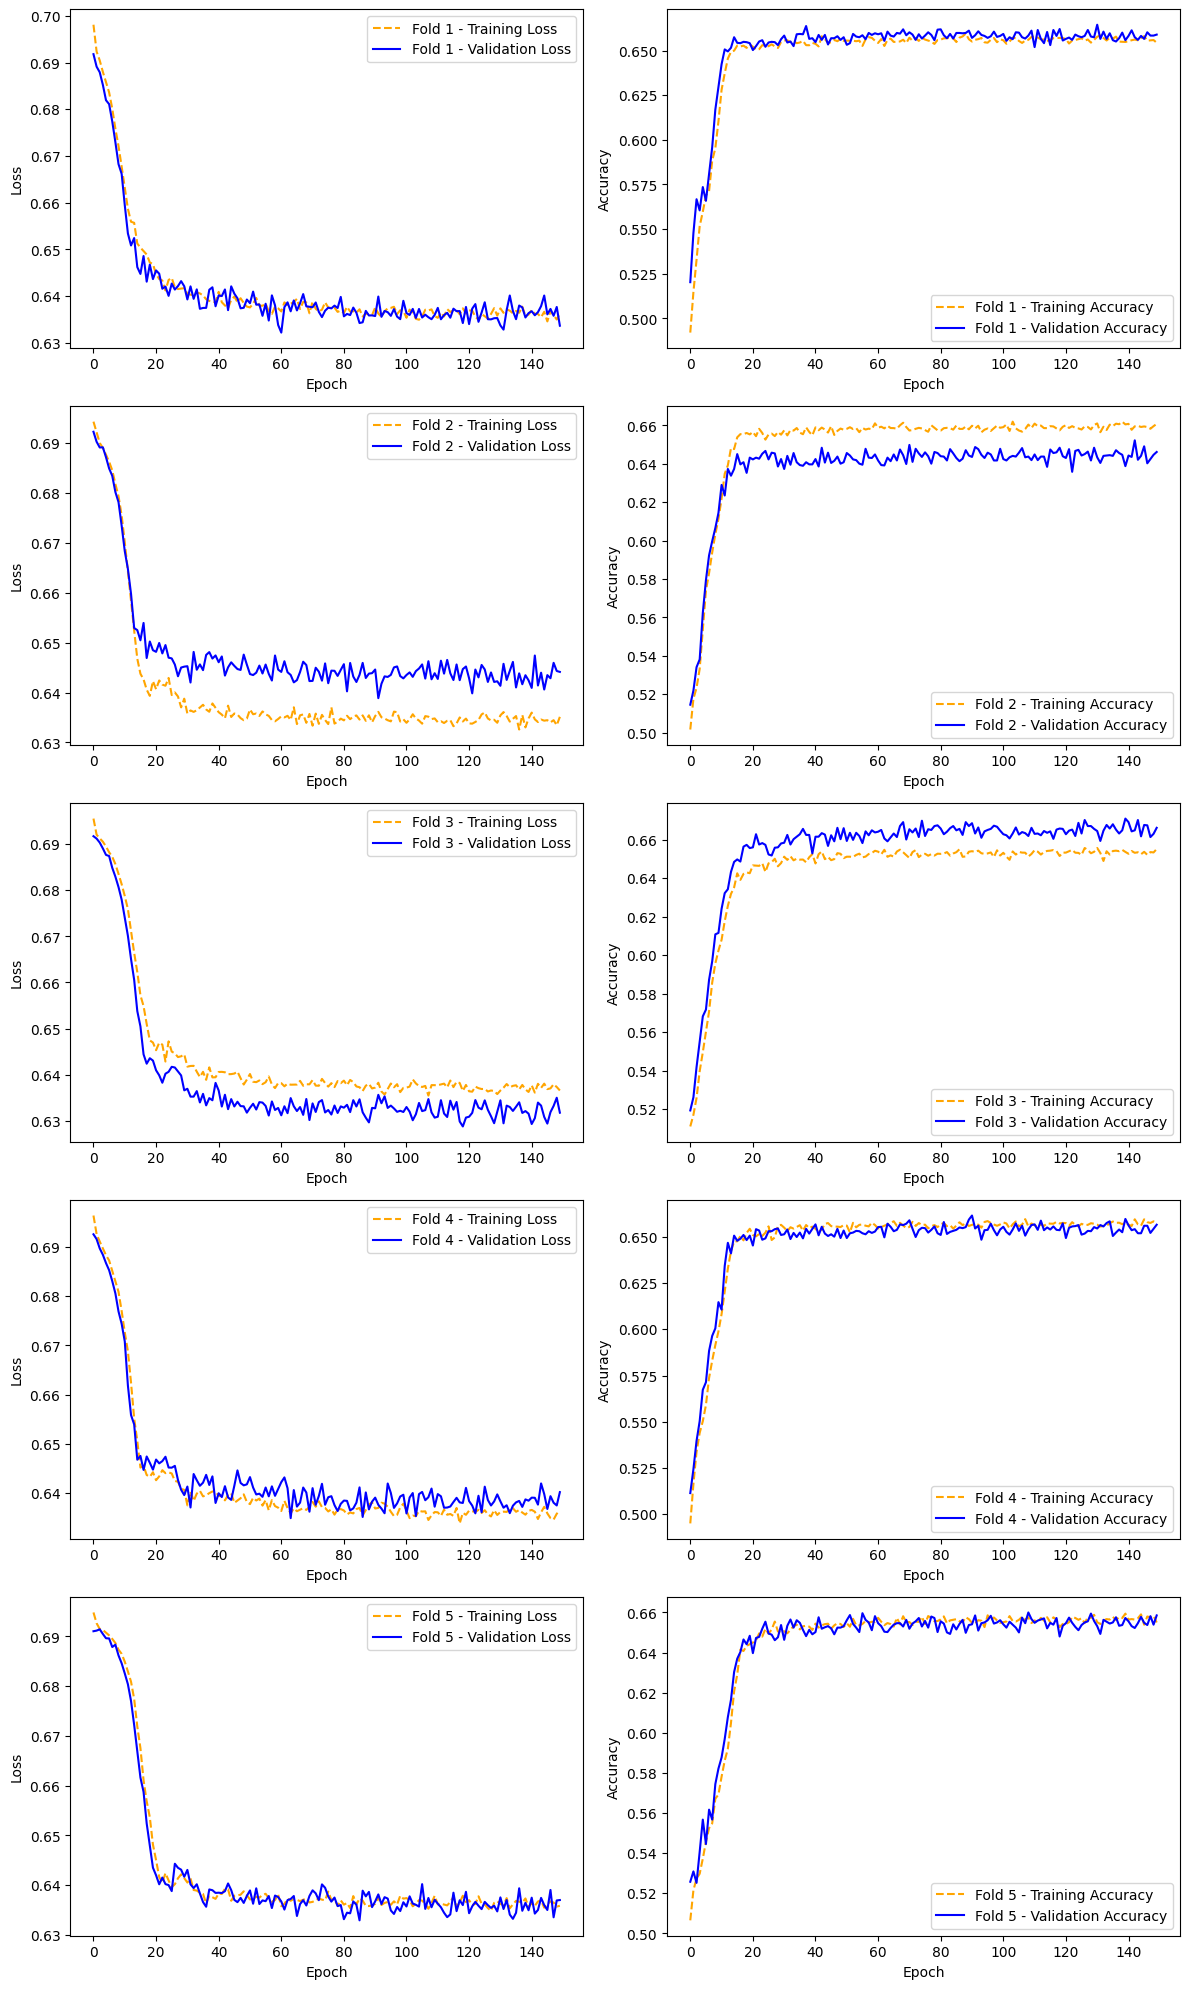

In [ ]:
# Assuming all_train_losses, all_val_losses, all_train_accuracies, and all_val_accuracies are lists of lists where each inner list corresponds to a fold.

# Plotting the training and validation loss and accuracy for each fold
num_folds = len(all_train_losses)

plt.figure(figsize=(12, 4 * num_folds))

for fold in range(num_folds):
    # Plotting training loss
    plt.subplot(num_folds, 2, fold * 2 + 1)
    plt.plot(all_train_losses[fold], label=f'Fold {fold + 1} - Training Loss', linestyle='--', color='orange')
    plt.plot(all_val_losses[fold], label=f'Fold {fold + 1} - Validation Loss', linestyle='-', color='blue')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plotting training accuracy
    plt.subplot(num_folds, 2, fold * 2 + 2)
    plt.plot(all_train_accuracies[fold], label=f'Fold {fold + 1} - Training Accuracy', linestyle='--', color='orange')
    plt.plot(all_val_accuracies[fold], label=f'Fold {fold + 1} - Validation Accuracy', linestyle='-', color='blue')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

plt.tight_layout()
plt.show()

## 2.8 TabNet

In [ ]:
#!pip install pytorch-tabnet
from pytorch_tabnet.tab_model import TabNetClassifier
from pytorch_tabnet.pretraining import TabNetPretrainer
from sklearn.metrics import accuracy_score
import torch

TabNetPretrainer
unsupervised_model = TabNetPretrainer(
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    mask_type='entmax' # "sparsemax"
)

unsupervised_model.fit(
    X_train=X_train,
    eval_set=[X_val],
    pretraining_ratio=0.8,
)

clf = TabNetClassifier(
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=7e-2),
    scheduler_params={"step_size":10, # how to use learning rate scheduler
                      "gamma":0.6},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    mask_type='sparsemax' # This will be overwritten if using pretrain model
)

clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    eval_name=['train', 'valid'],
    eval_metric=['accuracy'],
    from_unsupervised=unsupervised_model
)


# Make predictions on the training set
y_train_pred_tabnet = clf.predict(X_train)
accuracy_train_tabnet = accuracy_score(y_train, y_train_pred_tabnet)
print("TabNet Training Accuracy:", accuracy_train_tabnet)

# Make predictions on the validation set
y_val_pred_tabnet = clf.predict(X_val)
accuracy_val_tabnet = accuracy_score(y_val, y_val_pred_tabnet)
print("TabNet Validation Accuracy:", accuracy_val_tabnet)

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.9424  | val_0_unsup_loss_numpy: 1.0112899541854858|  0:00:05s
epoch 1  | loss: 1.00755 | val_0_unsup_loss_numpy: 1.0003299713134766|  0:00:09s
epoch 2  | loss: 0.98106 | val_0_unsup_loss_numpy: 0.9883099794387817|  0:00:12s
epoch 3  | loss: 0.99496 | val_0_unsup_loss_numpy: 0.9696800112724304|  0:00:15s
epoch 4  | loss: 0.97568 | val_0_unsup_loss_numpy: 0.9588800072669983|  0:00:19s
epoch 5  | loss: 0.97688 | val_0_unsup_loss_numpy: 0.9421200156211853|  0:00:25s
epoch 6  | loss: 0.94717 | val_0_unsup_loss_numpy: 0.9551399946212769|  0:00:28s
epoch 7  | loss: 0.94948 | val_0_unsup_loss_numpy: 0.9156299829483032|  0:00:32s
epoch 8  | loss: 0.96539 | val_0_unsup_loss_numpy: 0.8915200233459473|  0:00:33s
epoch 9  | loss: 0.94242 | val_0_unsup_loss_numpy: 0.839139997959137|  0:00:35s
epoch 10 | loss: 0.9223  | val_0_unsup_loss_numpy: 0.8404499888420105|  0:00:37s
epoch 11 | loss: 0.94123 | val_0_unsup_loss_numpy: 0.8704400062561035|  0:00:39s
epoch 12 | loss: 0.94891 | va

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:118: UserWarning: Pretraining: mask_type changed from sparsemax to entmax
  warnings.warn(wrn_msg)
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:248: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")


epoch 0  | loss: 0.75459 | train_accuracy: 0.54623 | valid_accuracy: 0.55006 |  0:00:02s
epoch 1  | loss: 0.68379 | train_accuracy: 0.57785 | valid_accuracy: 0.56721 |  0:00:04s
epoch 2  | loss: 0.64866 | train_accuracy: 0.65127 | valid_accuracy: 0.66236 |  0:00:06s
epoch 3  | loss: 0.63516 | train_accuracy: 0.65113 | valid_accuracy: 0.66089 |  0:00:08s
epoch 4  | loss: 0.63306 | train_accuracy: 0.65141 | valid_accuracy: 0.65148 |  0:00:10s
epoch 5  | loss: 0.63024 | train_accuracy: 0.64228 | valid_accuracy: 0.64282 |  0:00:11s
epoch 6  | loss: 0.63061 | train_accuracy: 0.65325 | valid_accuracy: 0.65794 |  0:00:13s
epoch 7  | loss: 0.62915 | train_accuracy: 0.65284 | valid_accuracy: 0.66329 |  0:00:16s
epoch 8  | loss: 0.62779 | train_accuracy: 0.65381 | valid_accuracy: 0.6655  |  0:00:18s
epoch 9  | loss: 0.62832 | train_accuracy: 0.65431 | valid_accuracy: 0.66476 |  0:00:21s
epoch 10 | loss: 0.62767 | train_accuracy: 0.65265 | valid_accuracy: 0.66439 |  0:00:22s
epoch 11 | loss: 0.62

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


TabNet Training Accuracy: 0.6538071533923304
TabNet Validation Accuracy: 0.6654988014014384


In [ ]:

reconstructed_X, embedded_X = unsupervised_model.predict(X_val.values)
assert(reconstructed_X.shape==embedded_X.shape)
unsupervised_explain_matrix, unsupervised_masks = unsupervised_model.explain(X_val.values)
fig, axs = plt.subplots(1, 3, figsize=(20,20))

for i in range(3):
    axs[i].imshow(unsupervised_masks[i][:50])
    axs[i].set_title(f"mask {i}")

AttributeError: ignored